# Business Impact 

Summarizing and categorizing reviews by their subject matter can save hundreds of reading hours. Instead, one can train a model on historical reviews and extract main topics mentioned. Then these topics can be used to quickly filter reviews and flag the ones requiring action. For example, the output of these insights can be used to address concerns about concierge service or to develop an approach for reaching out to unhappy customers. New incoming reviews can be automatically processed by the model, tagged with a topic, and passed along to appropriate channels for action. This also enables addressing issues quickly, and potentially retaining customers who otherwise would have churned.

# Method: 

We will use a technique called topic modeling, more specifically Latent Dirichlet Allocation LDA. LDA is one of the most widely used techniques for topic modeling. It is a generative probability model, meaning there is an assumed underlying probability distribution which generates the set of documents on hand. This makes it an appealing modeling option, as the generative model allows for scoring unseen documents.



In [ ]:
import pandas as pd
import numpy as np
import spacy
import re
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from nltk import FreqDist

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [336]:
df = pd.read_csv('central-bookingcom-review.csv',header=None)

In [337]:
rev=list([])
for data in df[1]:
    regex = re.compile('[^a-zA-Z ]')
    review=regex.sub('', str(data))
    rev.append(review)
df_rev=pd.DataFrame(rev,columns={'cust_review'})

In [338]:
df_rev.head(20)

,cust_review
0,they let me check in at am and check out late...
1,everything was worth the money
2,restroom has mole in shower so does the curtin...
3,Cheap
4,Dirty
5,this is actaul a nice hotel for the price the ...
6,the work of the one maid could have been bette...
7,I didnt like it
8,We both needed id
9,Price


# function to plot most frequent terms

In [297]:

def freq_words(x, terms = 35):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

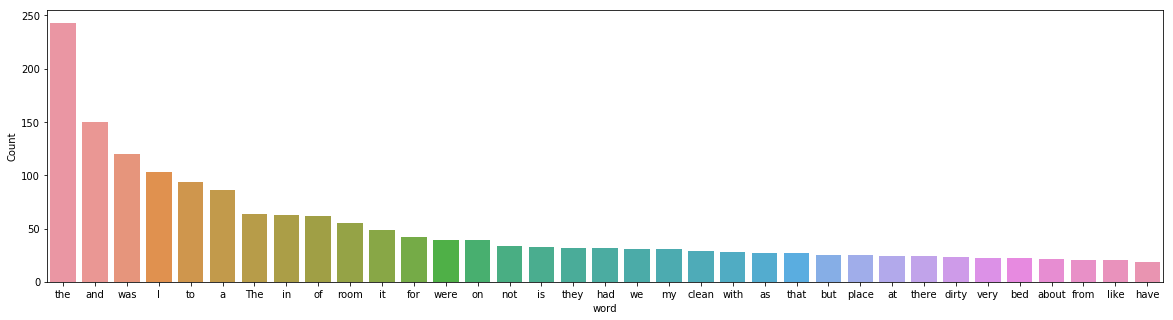

In [298]:
freq_words(df_rev['cust_review'])

Most common words are ‘the’, ‘and’, ‘was’, 'I','to, so on and so forth. These words are not so important for our task and they do not tell any story. We’ need to get rid of these kinds of words. 

# Preprocessing Task :

- Let’s try to remove the stopwords and short words (<2 letters) from the reviews

In [299]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [300]:
# Function to remove stop words

def remove_stopword(reve):
    review_new = ' '.join([i for i in reve if i not in stop_words])
    return review_new

# removing short words (<3)

df_rev['cust_review'] = df_rev['cust_review'].apply(lambda x: ' '.join([i for i in x.split() if len(i)>2]))

#removing stop words

#reviews = [remove_stopword(r.split()) for r in reviews['customer_reviews']]
reviews = [remove_stopword(r.split()) for r in df_rev['cust_review']]

# convert entire text in to lower case

reviews = [r.lower() for r in reviews]

In [301]:
len(reviews)

172

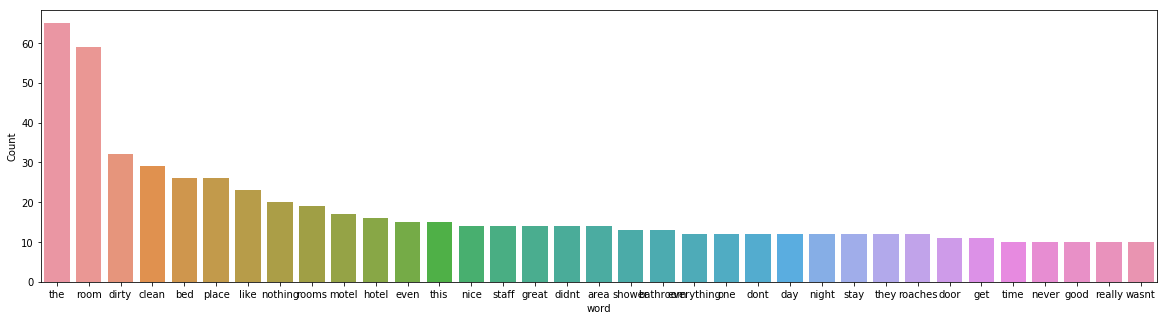

In [302]:
freq_words(reviews, 35)

In [303]:
import en_core_web_sm

nlp = en_core_web_sm.load()

In [304]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags ])
       return output

Let’s tokenize the reviews and then lemmatize the tokenized reviews.

In [305]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[5])

['actaul', 'nice', 'hotel', 'price', 'manager', 'staff', 'helpful', 'friendly', 'great', 'job', 'even', 'environment', 'keep', 'hotel', 'surroundings', 'calm', 'clean', 'possible', 'case', 'problems', 'police', 'came', 'assist', 'unfortunate', 'maid', 'one', 'best', 'room', 'never', 'done', 'end', 'morning', 'made', 'bed', 'good', 'managemend', 'maid', 'upper', 'floor', 'work', 'mate', 'often', 'helped', 'big', 'thank', 'small', 'table', 'eat', 'write', 'two', 'chairs', 'would', 'helpful', 'also', 'hangers', 'cloths', 'hotel', 'region', 'absolute', 'dont', 'recommend', 'women', 'travelling', 'alone', 'either', 'families', 'children', 'persons', 'without', 'car', 'day', 'problems', 'never', 'would', 'gone', 'hotel', 'dark', 'fights', 'able', 'watch', 'window', 'right', 'street', 'police', 'present', 'often', 'night', 'several', 'nights', 'police', 'helicopter', 'hours', 'night', 'police', 'present', 'environment', 'mexican', 'black', 'neighborhood', 'one', 'white', 'people', 'walk', 'ar

In [306]:
len(tokenized_reviews)

172

In [307]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[5]) # print lemmatized review

['actaul', 'nice', 'hotel', 'price', 'manager', 'staff', 'helpful', 'friendly', 'great', 'job', 'environment', 'hotel', 'surrounding', 'calm', 'clean', 'possible', 'case', 'problem', 'police', 'unfortunate', 'good', 'room', 'end', 'morning', 'bed', 'good', 'managemend', 'upper', 'floor', 'work', 'mate', 'big', 'small', 'table', 'chair', 'hanger', 'cloth', 'hotel', 'region', 'absolute', 'woman', 'family', 'child', 'person', 'car', 'day', 'problem', 'hotel', 'dark', 'fight', 'able', 'window', 'right', 'street', 'police', 'present', 'night', 'several', 'night', 'police', 'helicopter', 'hour', 'night', 'police', 'present', 'environment', 'mexican', 'black', 'neighborhood', 'white', 'people', 'night', 'hotel', 'safe', 'problem', 'concern', 'loud', 'outside', 'time']


In [308]:
len(reviews_2)

172

# Create Biagram & Trigram Models

In [309]:
from gensim.models import Phrases

# Add bigrams and trigrams to reviews_2, minimum count 5 means only that appear 5 times or more.

bigram = Phrases(reviews_2, min_count=5)
trigram = Phrases(bigram[reviews_2])

for idx in range(len(reviews_2)):
    for token in bigram[reviews_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            reviews_2[idx].append(token)
    for token in trigram[reviews_2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            reviews_2[idx].append(token)

As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.

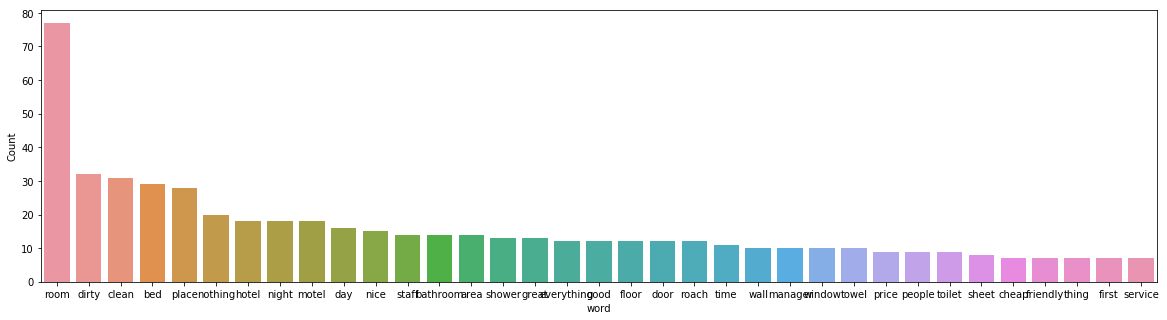

In [310]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df_rev['reviews'] = reviews_3

freq_words(df_rev['reviews'], 35)

It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

# Building LDA model

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index & then we will Remove rare & common tokens 

In [312]:
dictionary = corpora.Dictionary(reviews_2)

print('size of dictionary before filter: %d' % len(dictionary))

size of dictionary before filter: 572


In [313]:
dictionary.filter_extremes(no_below=2, no_above=0.2)

print('size of dictionary after filter: %d' % len(dictionary))

size of dictionary after filter: 200


Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.

In [314]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [315]:
len(doc_term_matrix)

172

# Training the Model

In [316]:
# Creating the object for LDA model using gensim library

LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=2,random_state=0,
                chunksize=160, passes=50)

In [317]:
lda_model.print_topics()

[(0,
  '0.033*"hotel" + 0.031*"clean" + 0.029*"staff" + 0.028*"great" + 0.027*"everything" + 0.022*"cheap" + 0.022*"place" + 0.019*"motel" + 0.017*"day" + 0.016*"mess"'),
 (1,
  '0.072*"bed" + 0.054*"dirty" + 0.051*"roach" + 0.041*"nothing" + 0.040*"floor" + 0.036*"place" + 0.030*"door" + 0.025*"first" + 0.025*"disgusting" + 0.025*"picture"')]

In [318]:

ldatopics=lda_model.show_topics(formatted=False)

In [319]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

In [320]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=reviews_2, dictionary=dictionary, window_size=10, coherence='c_v').get_coherence()

In [321]:
lda_coherence

0.3967555016525663

# Finding out the optimal number of topics

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [322]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LDA(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=0)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

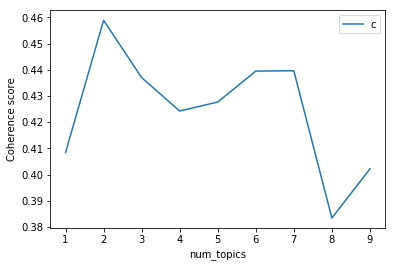

CPU times: user 3.96 s, sys: 404 ms, total: 4.37 s
Wall time: 4.57 s


In [323]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, limit=10)

# Topic coherence is a metric of topic quality, found to be correlated with human judgement. Higher topic coherence is better. We see that in this case, K = 2 has the highest coherence.

# For this reason we have trained our model choosing number of topic= 2 

# Topics Visualization

To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

pyLDAvis can be used to calculate term relevancy, with parameter  λ  controlling the order of terms for a selected topic. For example, topic 1 can be characterized by terms such as honeymoon, amazing, perfect. Decreasing  λ  brings up other positive terms such as romantic, incredible, etc. For brevity, we can assign label Happy Honeymooners to this topics. Similarly, other topics can also be assigned a label based on what terms customers tend to mention. Looks like historical reviews fall into one of the 2 main topics:

1. Happy customers
2. Customer complaints

In [324]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      71.550649        1       1  0.180266  0.0
1      28.449351        1       2 -0.180266  0.0, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
7     Default  21.000000            bed  21.000000  30.0000  30.0000
6     Default  16.000000          dirty  16.000000  29.0000  29.0000
111   Default  15.000000          roach  15.000000  28.0000  28.0000
15    Default  12.000000          floor  12.000000  27.0000  27.0000
77    Default  16.000000        nothing  16.000000  26.0000  26.0000
86    Default   9.000000           door   9.000000  25.0000  25.0000
85    Default   7.000000     disgusting   7.000000  24.0000  24.0000
157   Default   7.000000        picture   7.000000  23.0000  23.0000
65    Default   8.000000          first   8.000000  22.0000  22.0000
199   Default   7.000000           sure   7.000000  21.0000  21.0000
166   Default   7.000000         filthy   7.000000  20.0000  20.0000
127   Default  25.000000          place  25.000000  19.0000  19.0000
21    Default  23.000000          hotel  23.000000  18.0000  18.0000
11    Default  22.000000          clean  22.000000  17.0000  17.0000
55    Default   5.000000         toilet   5.000000  16.0000  16.0000
40    Default  20.000000          staff  20.000000  15.0000  15.0000
18    Default  20.000000          great  20.000000  14.0000  14.0000
58    Default   8.000000       bathroom   8.000000  13.0000  13.0000
0     Default  19.000000     everything  19.000000  12.0000  12.0000
79    Default   4.000000            bug   4.000000  11.0000  11.0000
82    Default   4.000000           last   4.000000  10.0000  10.0000
107   Default   4.000000       horrible   4.000000   9.0000   9.0000
141   Default   4.000000          trash   4.000000   8.0000   8.0000
98    Default   5.000000           much   5.000000   7.0000   7.0000
54    Default   6.000000          thing   6.000000   6.0000   6.0000
116   Default   4.000000       mattress   4.000000   5.0000   5.0000
78    Default   4.000000  uncomfortable   4.000000   4.0000   4.0000
90    Default   4.000000         second   4.000000   3.0000   3.0000
41    Default   5.000000         street   5.000000   2.0000   2.0000
67    Default   4.000000        mistake   4.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
79     Topic2   3.905806            bug   4.672769   1.0778  -4.2812
112    Topic2   3.522967           lamp   4.227776   1.0747  -4.3844
76     Topic2   3.520540        squeaky   4.233767   1.0726  -4.3851
174    Topic2   3.518709         charge   4.238284   1.0710  -4.3856
90     Topic2   3.702286         second   4.480158   1.0663  -4.3347
167    Topic2   3.511007           hate   4.257307   1.0643  -4.3878
163    Topic2   3.511007     additional   4.257307   1.0643  -4.3878
82     Topic2   3.885078           last   4.723975   1.0615  -4.2865
123    Topic2   3.507531          scary   4.265873   1.0613  -4.3888
153    Topic2   3.506194         drawer   4.269201   1.0601  -4.3892
67     Topic2   3.693960        mistake   4.500728   1.0595  -4.3370
107    Topic2   3.881815       horrible   4.732030   1.0590  -4.2874
141    Topic2   3.879759          trash   4.737113   1.0574  -4.2879
65     Topic2   7.180173          first   8.807517   1.0528  -3.6724
55     Topic2   4.795017         toilet   5.953014   1.0407  -4.0761
34     Topic2   3.445595       possible   4.418899   1.0083  -4.4066
98     Topic2   3.982178           much   5.179504   0.9942  -4.2619
33     Topic2   3.606254         person   4.717400   0.9885  -4.3610
41     Topic2   3.923215         street   5.325191   0.9515  -4.2768
77     Topic2  11.698869        nothing  16.822537   0.8938  -3.1842
127    Topic2  10.294721          place  25.856016   0.3361  -3.3121
58     Topic2   5.088488       bath

In [325]:
name_dict = {   0: "Happy Customer", # 1 on the chart
                1: "Customer complaints",    # 2 on the chart
            }

scored = lda_model[doc_term_matrix]
#topic_prob = map(lambda x: max(x, key=lambda item: item[1]), scored)
#scored_reviews = pd.DataFrame(list(zip(reviews_2, topic_prob)), columns=['Review', 'Main_Topic'])
#scored_reviews[['Topic', 'Prob']] = scored_reviews['Main_Topic'].apply(pd.Series)
#scored_reviews['Topic Name'] = scored_reviews['Topic'].map(name_dict)

In [326]:
topic_prob = map(lambda x: max(x, key=lambda item: item[1]), scored)
scored_reviews = pd.DataFrame(list(zip(reviews_2, topic_prob)), columns=['Review', 'Main_Topic'])

In [327]:
scored_reviews[:10]

,Review,Main_Topic
0,"[late, extra, fee]","(0, 0.5)"
1,"[everything, worth, money]","(0, 0.54825324)"
2,"[restroom, mole, shower, curtin, pubis, shower...","(0, 0.836654)"
3,[cheap],"(0, 0.74932367)"
4,[dirty],"(1, 0.7492329)"
5,"[actaul, nice, hotel, price, manager, staff, h...","(0, 0.9186726)"
6,"[maid, sad, day, thing, day, time, towel, good...","(0, 0.7763421)"
7,[],"(0, 0.5)"
8,[],"(0, 0.5)"
9,[price],"(0, 0.74824417)"


In [328]:
len(scored_reviews)

172

In [329]:
scored_reviews[['Topic', 'Prob']] = scored_reviews['Main_Topic'].apply(pd.Series)

In [330]:
scored_reviews[:10]

,Review,Main_Topic,Topic,Prob
0,"[late, extra, fee]","(0, 0.5)",0.0,0.500000
1,"[everything, worth, money]","(0, 0.54825324)",0.0,0.548253
2,"[restroom, mole, shower, curtin, pubis, shower...","(0, 0.836654)",0.0,0.836654
3,[cheap],"(0, 0.74932367)",0.0,0.749324
4,[dirty],"(1, 0.7492329)",1.0,0.749233
5,"[actaul, nice, hotel, price, manager, staff, h...","(0, 0.9186726)",0.0,0.918673
6,"[maid, sad, day, thing, day, time, towel, good...","(0, 0.7763421)",0.0,0.776342
7,[],"(0, 0.5)",0.0,0.500000
8,[],"(0, 0.5)",0.0,0.500000
9,[price],"(0, 0.74824417)",0.0,0.748244


In [331]:
scored_reviews['Topic Name'] = scored_reviews['Topic'].map(name_dict)

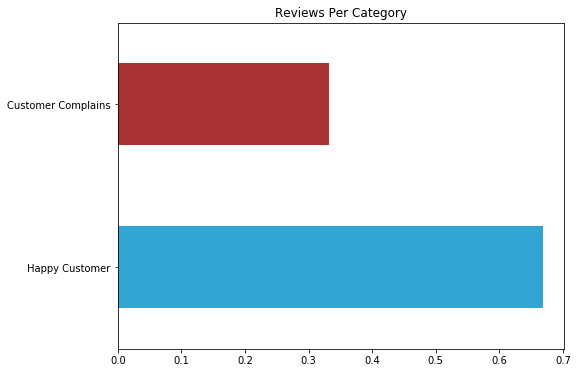

In [332]:
df_2 = scored_reviews['Topic Name'].value_counts(normalize=True)

plt.rcParams['axes.facecolor'] = 'white'
ax = df_2.plot(kind='barh', figsize=[8,6], title='Reviews Per Category', color='#33A5D3')
pos = df_2.index.get_loc('Customer Complains')
ax.patches[pos].set_facecolor('#aa3333')

In [333]:
df_2

Happy Customer        0.668605
Customer Complains    0.331395
Name: Topic Name, dtype: float64

# The goal of this analysis is twofold:

1. Reduce number of human hours spent on review reading and categorizing
2. Increase customer retention by addressing concernes in a timely manner

# Saving human hours of reading through reviews will help to improve other customer satisfaction metrics such as:

1. Response time
2. Number of review replies and complaints addressed
3. Customer likelihood to recommend (net promoter score)
4. Customer ratings
5. Customer retention

# Conclusion:

- Now that we have trained the model and labeled review categories, the final and perhaps most important step is to utilize model results. In     this particular use case, one could consider:

- Feeding new review summaries along with labels based on found topics into a BI tool to be presented to customer service representatives
  Problematic reviews can be filtered and brought to attention

- Topic categories can be tracked through time to monitor trends in customer feedback

- This application of topic modeling is meant to show how unsupervised models can save time by summarizing text into managable categories.       Every data set is different, and often topic modeling is just the first step in making sense of text data. 

- However, even with a simple model as demonstrated here, one can start gaining valuable insights about customers by quickly summarizing and     visualizing reviews.